# Analysis Forecasting and Prediction

In [ ]:

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
import os
import datetime

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Preprocessing 
The data used for this analysis is provided by nyc.gov ( under NYC health COVID-19 Downloadable Data) link : https://www1.nyc.gov/assets/doh/downloads/pdf/imm/covid-19-daily-data-summary.pdf

In [ ]:
# https://github.com/nychealth/coronavirus-data/blob/master/case-hosp-death.csv

df = pd.read_csv('/content/NYC_data.csv')
df.head()

,DATE_OF_INTEREST,CASE_COUNT,HOSPITALIZED_COUNT,DEATH_COUNT
0,02/29/2020,1,14,0
1,03/01/2020,1,4,0
2,03/02/2020,0,23,0
3,03/03/2020,2,22,0
4,03/04/2020,5,22,0


In [ ]:
# data preprocessing for Forecasting and visualization 
df = df.drop(columns = ['CASE_COUNT' , 'DEATH_COUNT'])
#df = df [df['CASE_COUNT'] != 0 ]

print(type(list(df['DATE_OF_INTEREST'])[0])) 

df.head()

<class 'str'>


,DATE_OF_INTEREST,HOSPITALIZED_COUNT
0,02/29/2020,14
1,03/01/2020,4
2,03/02/2020,23
3,03/03/2020,22
4,03/04/2020,22


In [ ]:
 
df['DATE_OF_INTEREST'] = pd.to_datetime(df['DATE_OF_INTEREST'])

df.drop(df.tail(1).index,inplace=True) 

print('Time period start: {}\nTime period end: {}'.format(df.DATE_OF_INTEREST.min(),df.DATE_OF_INTEREST.max()))

Time period start: 2020-02-29 00:00:00
Time period end: 2020-05-28 00:00:00


In [ ]:
print(type(list(df['DATE_OF_INTEREST'])[0])) 
y = df.set_index('DATE_OF_INTEREST')
y

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


,HOSPITALIZED_COUNT
DATE_OF_INTEREST,
2020-02-29,14
2020-03-01,4
2020-03-02,23
2020-03-03,22
2020-03-04,22
...,...
2020-05-24,75
2020-05-25,63
2020-05-26,81


In [ ]:
print(df.shape)  
print(y.shape) 



(90, 2)
(90, 1)


# 1. Visualization  and Forecasting

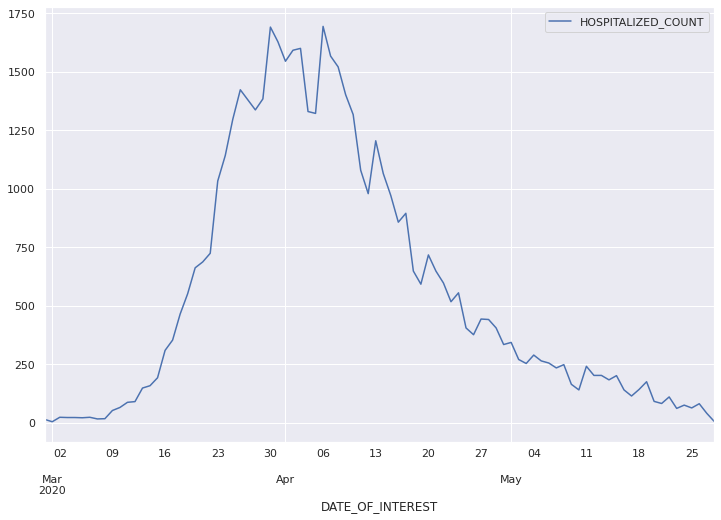

In [ ]:

sns.set()
y.plot(figsize = (12 ,8))


Reviewing plots of the density of observations can provide further insight into the structure of the data:
from the plots we can say that 
The distribution is not perfectly Gaussian (normal distribution) and is left shifted, but not too much. Transformations may or may not  be useful prior to modelling. more analysis needed

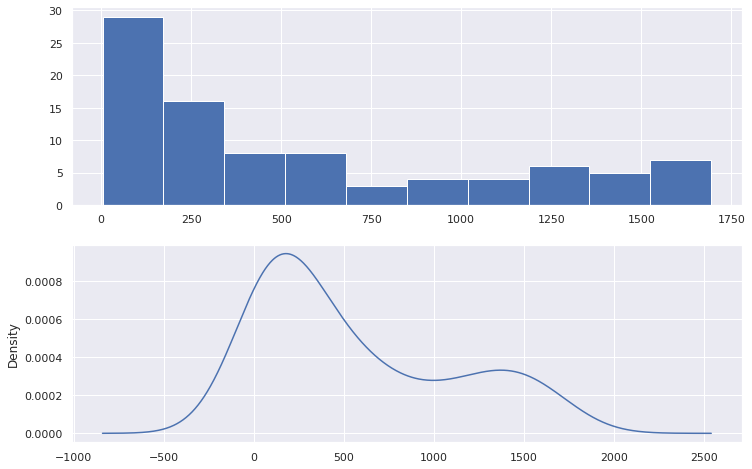

In [ ]:
 
plt.figure(1 , figsize=(12, 8))

plt.subplot(211)
y.HOSPITALIZED_COUNT.hist()
plt.subplot(212)
y.HOSPITALIZED_COUNT.plot(kind='kde')
plt.show()


# Decomposing using statsmodel:


With statsmodels we will be able to see the trend, seasonal, and residual components of our data.

In [ ]:
# imports for stats model 

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA



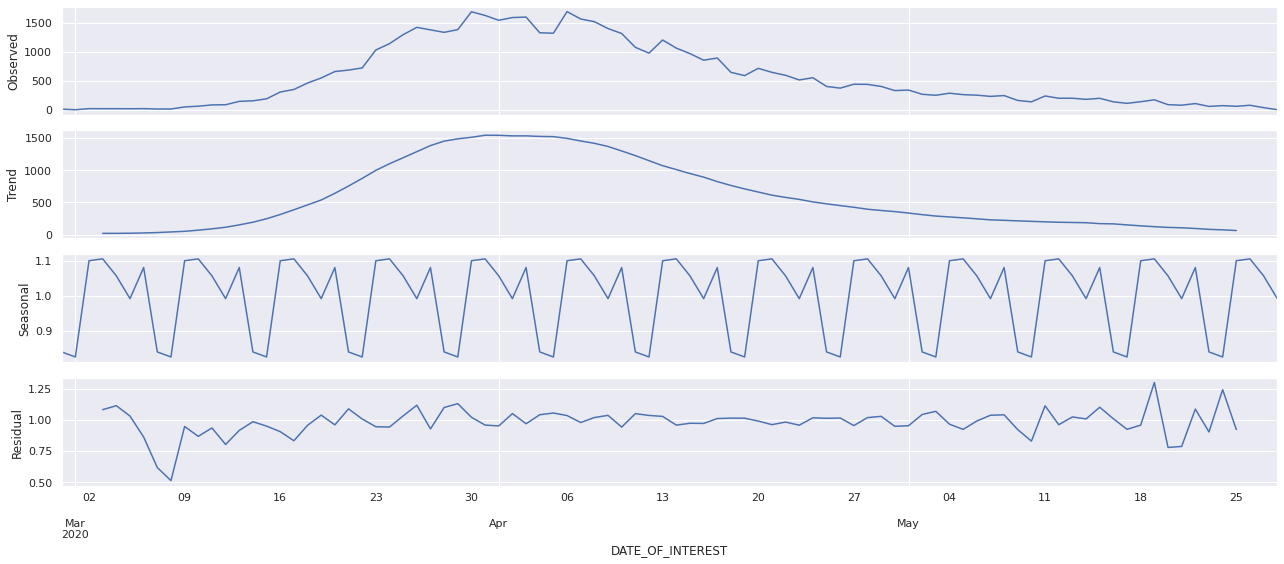

In [ ]:
sns.set()
from pylab import rcParams
rcParams['figure.figsize'] = 18,8
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')
fig = decomposition.plot()
plt.show()


# Stationarity
If a Time Series has a particular behaviour over time, there is a very high probability that it will follow the same in the future.
 

# checking the stationarity :

 
Plotting Rolling Statistics: 

Augmented Dickey-Fuller Test:
 

reference : https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/

In [ ]:
# cheacking the Stationarity 

def test_stationarity(timeseries):
    sns.set()
    
    #rolling statistics
    rolmean = timeseries.rolling(5).mean() 
    rolstd = timeseries.rolling(5).std() 

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)


    if dfoutput[1] <= 0.05:
        print("  \n\n strong evidence against the null hypothesis(Ho), reject the null hypothesis.\n\n Data has no unit root and is stationary")
    else:
        print("  \n\n weak evidence against null hypothesis, time series has a unit root, \n\n indicating it is non-stationary ")

    

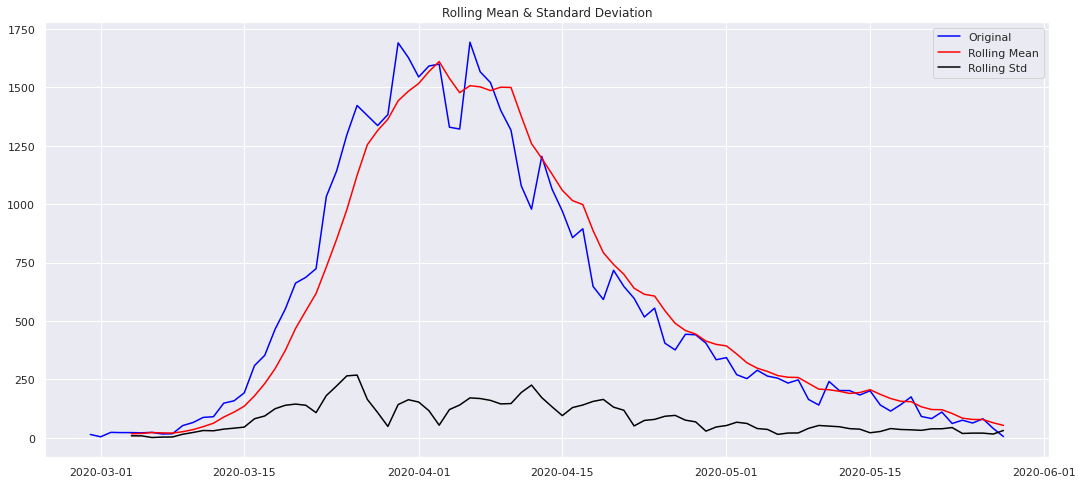

Results of Dickey-Fuller Test:
Test Statistic                 -3.806117
p-value                         0.002845
#Lags Used                      7.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64
  

 strong evidence against the null hypothesis(Ho), reject the null hypothesis.

 Data has no unit root and is stationary


In [ ]:
test_stationarity(y.HOSPITALIZED_COUNT.dropna())

#  our time series data is stationary 

as p-value is < 0.05 giving us considerably strong evidence against the null hypothesis 

and the Test Statistic value is less than the 1% Critical value 

# Plot ACF and PACF 
To decide which model to be used  for forcasting 



/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


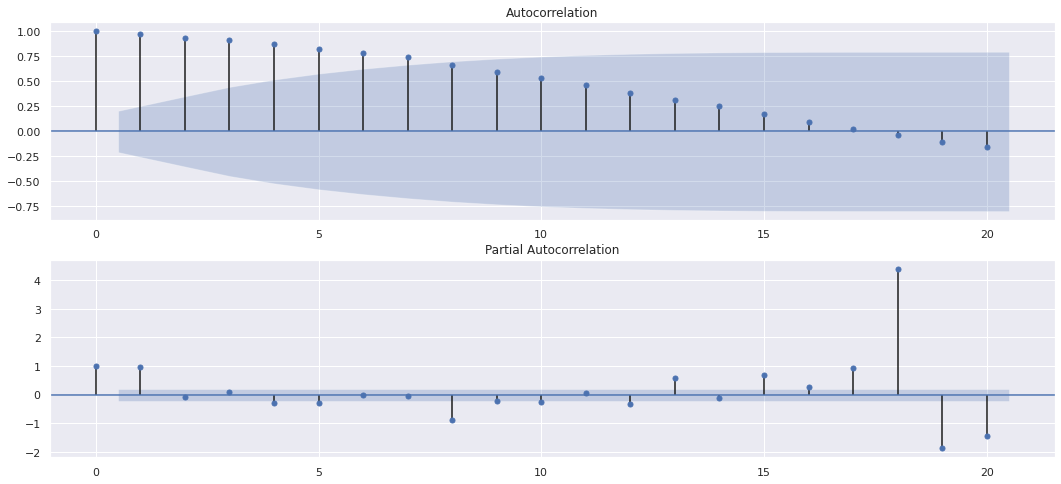

In [ ]:
# to decide the values of p q and d we plot ACF and PACF plots 

plt.figure()
plt.subplot(211)
plot_acf(y, ax=plt.gca(),lags=20)
plt.subplot(212)
plot_pacf(y, ax=plt.gca(),lags=20)
plt.show()

# From the shape of ACF plot  we can say  that AR(Auto-Regressive)  model would be the best choice 
 

# AR (Auto-Regressive) model  :


The autoregression (AR) method models the next step in the sequence as a linear function of the observations at prior time steps.
 



In [ ]:
from statsmodels.tsa.ar_model import AR
from random import random

In [ ]:
# fit model
model = AR(y)
model_fit = model.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


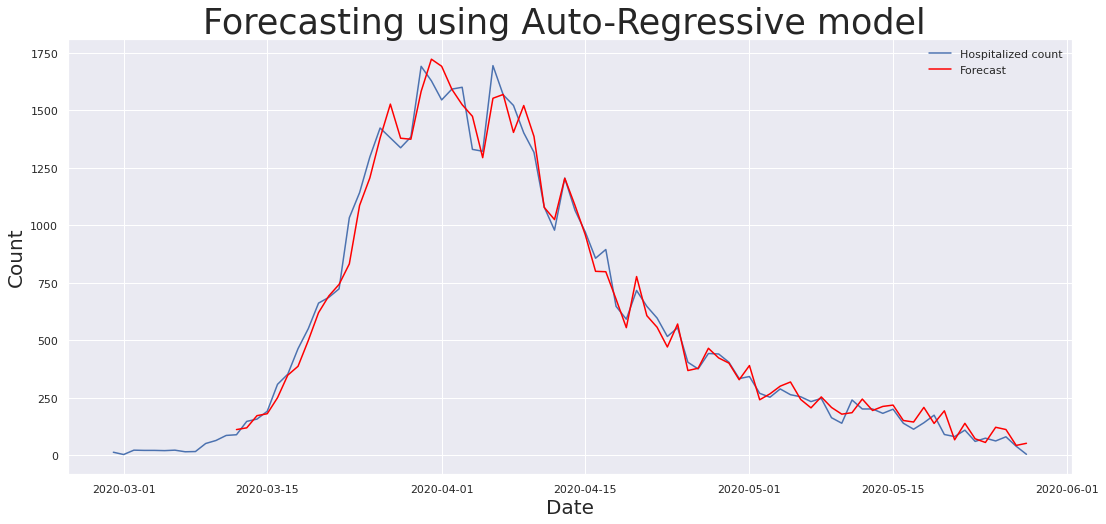

In [ ]:
plt.plot(y , label='Hospitalized count' ) #HOSPITALIZED_COUNT
plt.plot(model_fit.fittedvalues, color='red' , label='Forecast' )
plt.legend(loc='upper right', frameon=False)
plt.title('Forecasting using Auto-Regressive model ' , fontsize = 35 )
plt.xlabel('Date' , fontsize = 20 )
plt.ylabel('Count' , fontsize = 20 )

plt.show()

# Forecast quality scoring metrics
R squared coefficient of determination   

Mean Absolute Error  
 
Mean Squared Error    

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [ ]:
pred = pd.Series(model_fit.fittedvalues, copy=True)
print(pred)


DATE_OF_INTEREST
2020-03-12    112.437811
2020-03-13    120.027353
2020-03-14    172.922362
2020-03-15    181.312985
2020-03-16    250.844061
                 ...    
2020-05-24     56.476622
2020-05-25    122.412587
2020-05-26    112.705791
2020-05-27     43.664693
2020-05-28     52.809284
Length: 78, dtype: float64


In [ ]:
# R-squared is a goodness-of-fit measure for linear regression models.
r2_score(list(y.HOSPITALIZED_COUNT)[12:] , pred)

0.9867368500510751

In [ ]:
mean_absolute_error(list(y.HOSPITALIZED_COUNT)[12:] , pred)

44.43559222121799

In [ ]:

mean_squared_error(list(y.HOSPITALIZED_COUNT)[12:] , pred)

3672.7676969122444

# 2. Prediction 

For prediction we will use Bidirectional LSTM 

The LSTM model will learn a function that maps a sequence of past observations as input to an output observation. As such, the sequence of observations must be transformed into multiple examples from which the LSTM can learn.


In [ ]:
data = list(y.HOSPITALIZED_COUNT)
# here we will train our model with 90 % of the data since our model maps a past sequence to a single o/p.
data_train = data[: int(0.90*(len(data)))] # 81  # total 90 
data_test  = data[int(0.90*(len(data))):]

In [ ]:
# imports 
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional

Using TensorFlow backend.


In [ ]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		end_ix = i + n_steps
 
		if end_ix > len(sequence)-1:
			break
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [ ]:
n_steps = 5
X, Y = split_sequence(data_train, n_steps)
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features)) # reshape from [samples, timesteps] into [samples, timesteps, features]

In [ ]:
# define model
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
# fit model
model.fit(X, Y, epochs=200, verbose=0)

# Check the prediction 

In [ ]:
#Actual Values
#Predicted Values 
av = []
pv = []
for i in range( 5 ,len(data)  ):
  seq = [ data[i-5] , data[i-4] , data[i-3] , data[i-2] , data[i-1] ]
  x_input = array(seq)
  x_input = x_input.reshape((1, n_steps, n_features))
  yhat = model.predict(x_input, verbose=0)
  av.append(data[i])
  pv.append(int(yhat[0][0]))

test_res = pd.DataFrame({"Actual Values" : av , "Predicted Values" : pv})
test_res


,Actual Values,Predicted Values
0,21,19
1,23,21
2,16,16
3,17,11
4,52,48
...,...,...
80,75,77
81,63,78
82,81,69
83,40,70


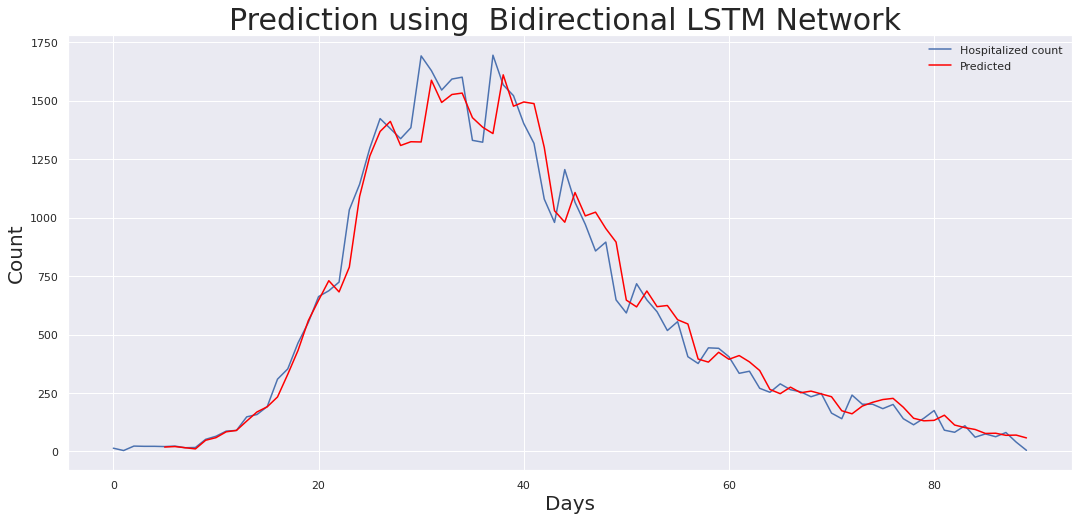

In [ ]:
yy = [i for i in range(len(data))]

plt.plot( yy, data ,  label='Hospitalized count' ) # [:int(0.90*(len(data)))]
plt.plot( yy[5:]  , test_res["Predicted Values"]  , color='red' , label='Predicted' )
plt.legend(loc='upper right', frameon=False)
plt.title('Prediction using  Bidirectional LSTM Network ' , fontsize = 30 )
plt.xlabel('Days' , fontsize = 20 )
plt.ylabel('Count' , fontsize = 20 )
plt.show()